## Programming Exercise 6

### Setup
This loads the required modules. No other modules are necessary to successfully finish this exercise.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, img_as_ubyte
from skimage.transform import resize
from scipy import signal
import splines

### 6.1 Spline Interpolation

#### 6.1.1

Write a function `spline_b0(x)` calculating the zero-order B-spline basis function. Plot the zero-order B-spline basis function in the range $x \in [-2, 2]$.

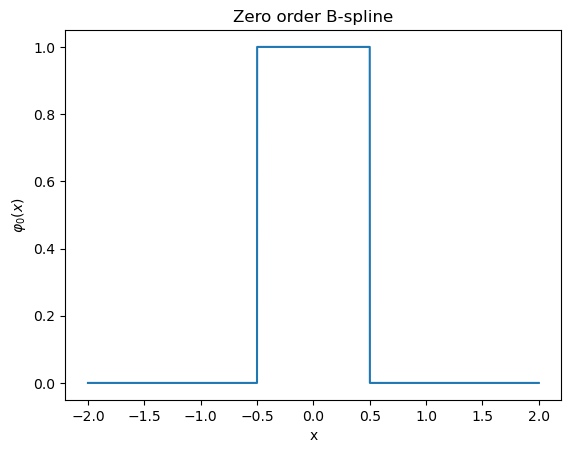

In [2]:
def spline_b0(x):
    x=np.array(x)
    return np.where(np.abs(x)<0.5,1,0)

x=np.linspace(-2,2,10000)
plt.plot(x,spline_b0(x))
plt.xlabel("x")
plt.ylabel(r"$\varphi_0(x)$")
plt.title("Zero order B-spline")

plt.show()

#### 6.1.2

Write a function `spline_bn(x, n)` calculating the B-spline of order `n` using recursion and numeric convolution. Plot the B-spline basis functions of order $n \in [1, 3]$ in the range $x \in [-2, 2]$. Which issues evolve if you choose the number of sampling positions too low?

*Hint: The `np.convolve` function ([docs](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html)) might be useful. You'll have to take care of the scaling as `np.convolve` does not know about your sampling stepsize.* 

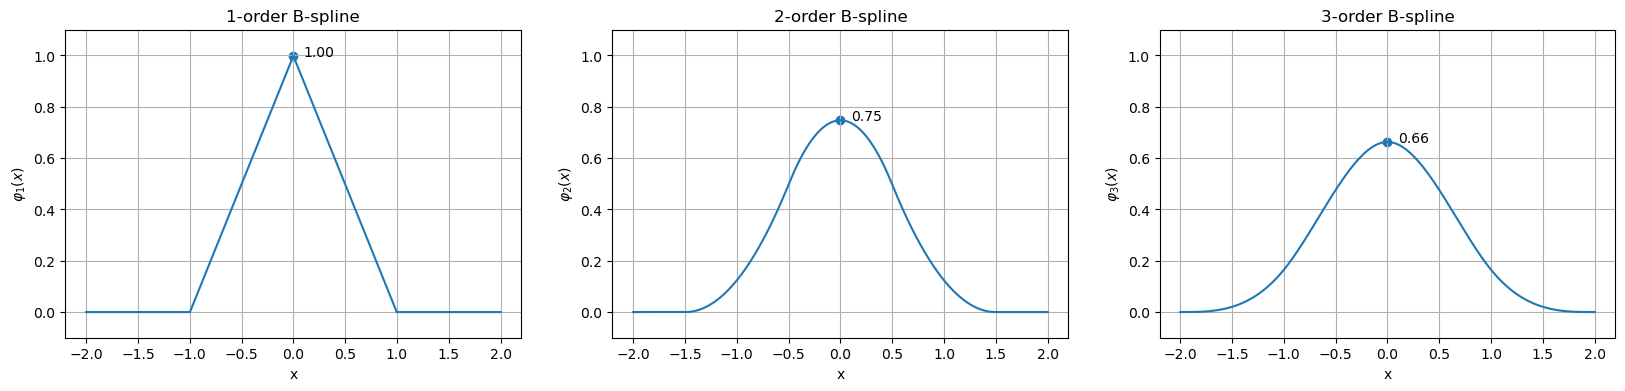

In [3]:
def spline_bn(x,n):
    if n==0:
        return spline_b0(x)
    else:
        return np.convolve(spline_b0(x),spline_bn(x,n-1),mode="same")
N=1000
x=np.linspace(-2,2,2*N+1)
dx=x[1]-x[0]
fig,axs=plt.subplots(1,3,figsize=(20,4))
for i ,n in enumerate(range(1,4)):
    phi_n=spline_bn(x,n)*np.power(dx,n)
    axs[i].plot(x,phi_n)
    axs[i].scatter(x[N],phi_n[N])
    axs[i].text(x[N] + 0.1, phi_n[N], f"{phi_n[N]:.2f}")
    axs[i].set_title(f"{n}-order B-spline")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel(f"$\\varphi_{n}(x)$")
    axs[i].grid()
    axs[i].set_ylim(-0.1, 1.1)
plt.show()
    


#### 6.1.3

To alleviate the numerical issues found in Subtask 5.1.2, the linear, quadratic and cubic spline basis functions are implemented analytically as `spline_b1`, `spline_b2`, and `spline_b3` in the provided python module `splines`. Plot the provided basis functions in the range $x \in [-2, 2]$ and compare the results with the numerically obtained results from Subtask 5.1.2.

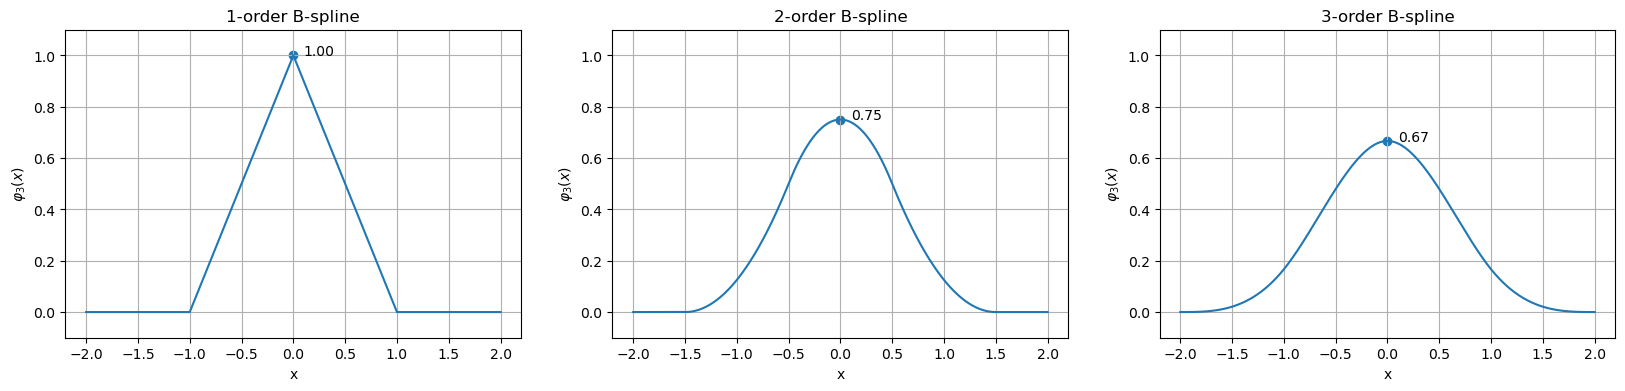

In [4]:
N = 1000
x = np.linspace(-2, 2, 2 * N + 1)
fix, axs = plt.subplots(1, 3, figsize=(20, 4))
for i, func in enumerate([splines.spline_b1, splines.spline_b2, splines.spline_b3]):
    phi_n = func(x)
    axs[i].plot(x, phi_n)
    axs[i].scatter(x[N], phi_n[N])
    axs[i].text(x[N] + 0.1, phi_n[N], f"{phi_n[N]:.2f}")
    axs[i].set_title(f"{i+1}-order B-spline")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel(f"$\\varphi_{n}(x)$")
    axs[i].grid()
    axs[i].set_ylim(-0.1, 1.1)
plt.show()

#### 6.1.4

Write a function `weighted_splines(coeffs, x, n)` that calculates the weighted superposition of the appropriately shifted `n`-th order B-splines based on the spline coefficients `coeffs` at the sampling positions `x` as

$$ y(x) = \sum_i c_i \varphi_n(x - i), $$

where $y$ are the sampled (interpolated) signal values, $c_i$ are the spline coefficients and $\varphi_n$ is the n-th order B-spline basis function.

In [6]:
def spline_func(n):
    if n == 0:
        return spline_b0
    elif n == 1:
        return splines.spline_b1
    elif n == 2:
        return splines.spline_b2
    elif n == 3:
        return splines.spline_b3
    else:
        raise RuntimeError("Unsupported spline order.")
def weighted_splines(coeffs,x,n):
    x=np.array(x)
    spline=spline_func(n)
    y=np.zeros_like(x)
    for i,c in enumerate(coeffs):
        y+=c*spline(x-i)
    return y


#### 6.1.5

Write a function `spline_coeffs(y, n)` that calculates the spline coefficients for `n`-th order B-spline basis functions given the sampled signal values `y` based on

$$ \mathbf{y} = \mathbf{A} \mathbf{c}. $$

Setup the constraint matrix $\mathbf{A}$ for the n-th order B-spline and solve for the unknown spline coefficients $\mathbf{c}$. The constraint matrix is setup such that the available samples $\mathbf{y}$ are exactly reconstruced by the weighted superposition of the B-splines.

*Hint: The `np.linalg.inv` function ([docs](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)) might be useful.*

In [7]:
def spline_coeffs(y,n):
    spline=spline_func(n)
    N=y.shape[0]
    x=np.arange(0,N)
    A=np.empty((N,N))   
    for i in range(N):
        A[i,: ]=spline(x-i)
    c=np.linalg.inv(A).dot(y)
    return c


#### 6.1.6

Let's upsample the image `zebra` using the implemented spline interpolation from Subtasks 5.1.4 and 5.1.5. Proceed as follows:
* Go through each row of the `image` and upsample it by the given `factor` using the functions `spline_coeffs` and `weighed_splines`.
* Go through each column of the "row-upsampled" image and upsample it by the given `factor` using the functions `spline_coeffs` and `weighted_splines`.
* Display the original image and the interpolated image, try different B-spline orders.

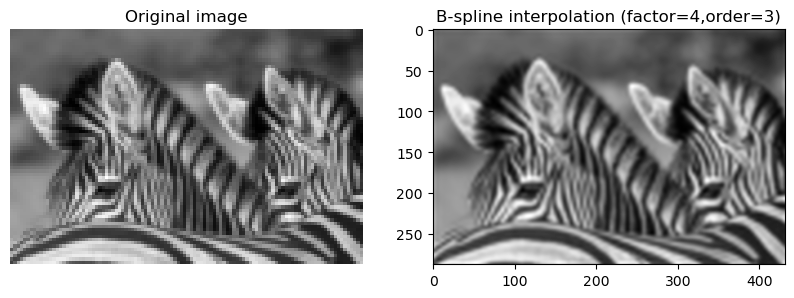

In [8]:
image=img_as_float(color.rgb2gray(io.imread("./resources/zebra.jpg")))
image=resize(image,(72,108),anti_aliasing=True) 
factor=4
n=3
image_interp=np.zeros((factor*image.shape[0],factor*image.shape[1]))    
x=np.linspace(0,image.shape[1]-1,image.shape[1]*factor)
for i in range(image.shape[0]):
    coeffs=spline_coeffs(image[i,:],n)
    image_interp[i*factor,:]=weighted_splines(coeffs,x,n)
x=np.linspace(0,image.shape[0]-1,image.shape[0]*factor)
for j in range(image_interp.shape[1]):
    coeffs=spline_coeffs(image_interp[::factor,j],n)
    image_interp[:,j]=weighted_splines(coeffs,x,n)


fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(image,cmap="gray")
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(image_interp,cmap="gray")
axs[1].set_title(f"B-spline interpolation (factor={factor},order={n})")
plt.show()
